In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder, StandardScaler
from imblearn.over_sampling import SMOTE
import xgboost as xgb
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

# Load dataset
file_path = 'D:/Attack/CTDAPD Dataset.csv'
dataset = pd.read_csv(file_path)

# Preprocess the dataset
# Encode 'Label' column manually to ensure Normal = 0 and Attack = 1
dataset['Label'] = dataset['Label'].map({'Normal': 0, 'Attack': 1})

# Map 'Attack_Severity' to 'Low', 'Medium', 'High' as numeric values (target for prediction)
severity_mapping = {'Low': 0, 'Medium': 1, 'High': 2}
dataset['Attack_Severity'] = dataset['Attack_Severity'].map(severity_mapping)

Missing values in dataset:
 Date                               0
Source_IP                          0
Destination_IP                     0
Source_Port                        0
Destination_Port                   0
Protocol_Type                      0
Flow_Duration                      0
Packet_Size                        0
Flow_Bytes_per_s                   0
Flow_Packets_per_s                 0
Total_Forward_Packets              0
Total_Backward_Packets             0
Packet_Length_Mean_Forward         0
Packet_Length_Mean_Backward        0
IAT_Forward                        0
IAT_Backward                       0
Active_Duration                    0
Idle_Duration                      0
IDS_Alert_Count                    0
Anomaly_Score                      0
Attack_Vector                  43835
Attack_Severity                    0
Botnet_Family                  49223
Malware_Type                   51551
CPU_Utilization                    0
Memory_Utilization                 0
System_Pat

c:\Users\LENOVO\AppData\Local\Programs\Python\Python313\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_7532\967129007.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Label', data=dataset, palette='Set2')


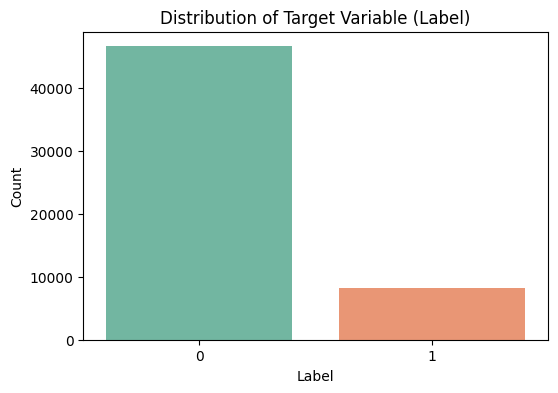

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_7532\967129007.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Attack_Severity', data=dataset, palette='Set3')


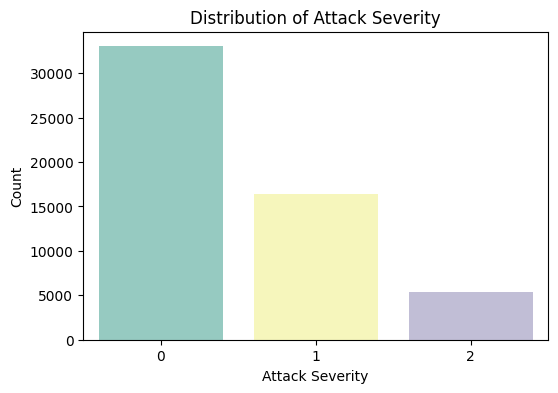

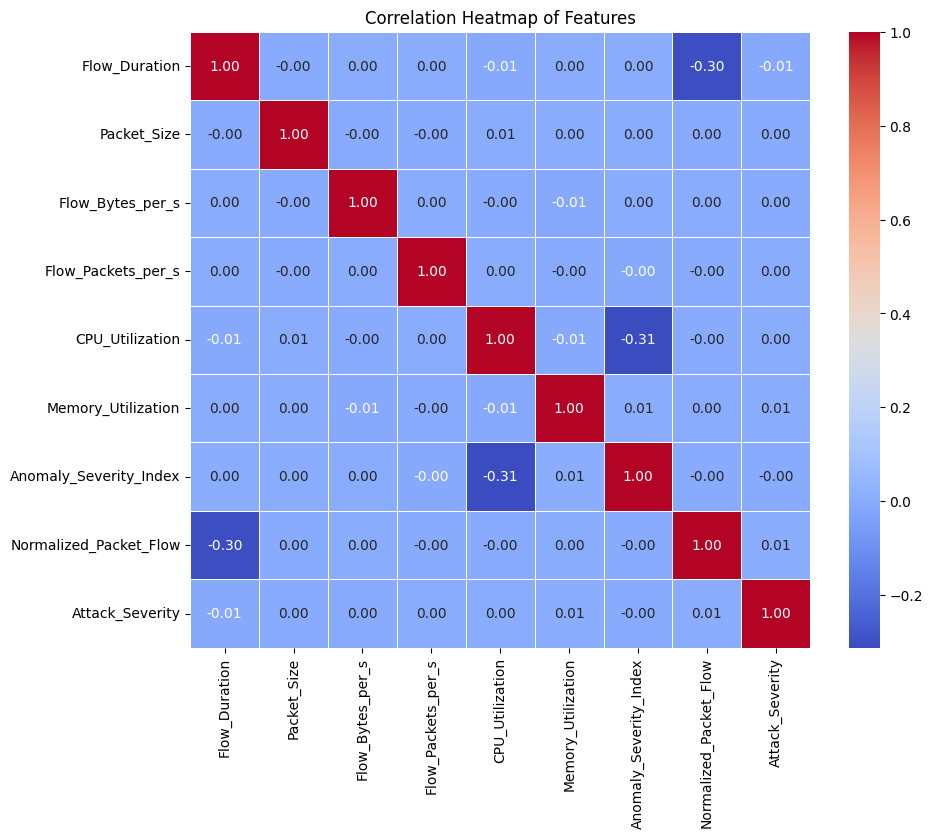

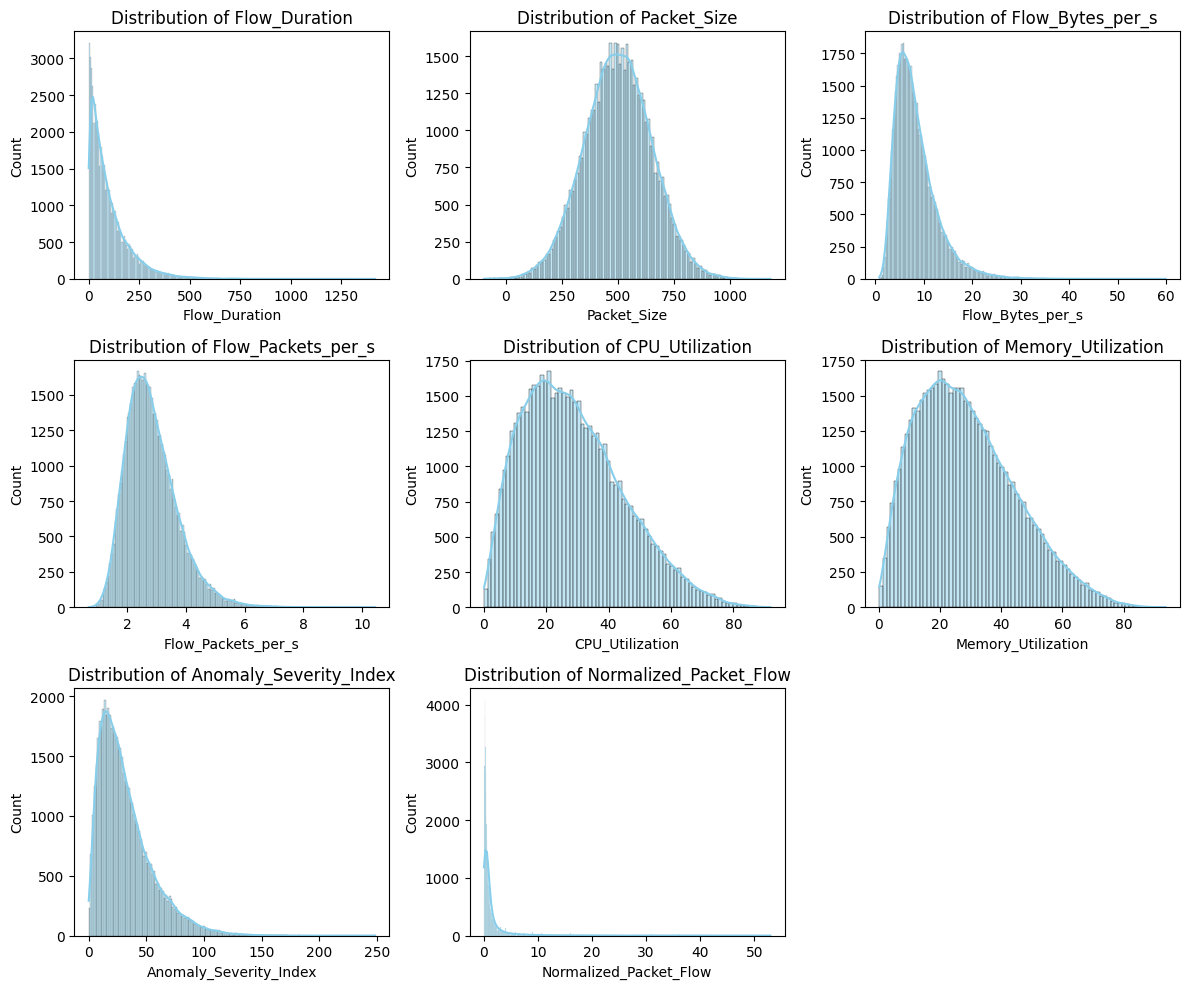

In [5]:
# EDA: Check for missing values and data types
print("Missing values in dataset:\n", dataset.isnull().sum())
print("\nData types in dataset:\n", dataset.dtypes)

# Select features and target variable (Attack_Severity for prediction)
features = ['Flow_Duration', 'Packet_Size', 'Flow_Bytes_per_s', 'Flow_Packets_per_s', 
            'CPU_Utilization', 'Memory_Utilization', 'Anomaly_Severity_Index', 
            'Normalized_Packet_Flow', 'Attack_Severity']
X = dataset[features]
y = dataset['Label']  # Target variable: Attack_Severity (Low, Medium, High)

# Clean the data: replace inf/-inf with NaN, then fill NaN with column mean
X = X.replace([np.inf, -np.inf], np.nan)
X = X.fillna(X.mean())

# Basic statistics for numerical columns
print("\nDescriptive statistics:\n", dataset.describe())

# Visualizing the distribution of target variable (Label)
plt.figure(figsize=(6, 4))
sns.countplot(x='Label', data=dataset, palette='Set2')
plt.title('Distribution of Target Variable (Label)')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

# Visualizing the distribution of 'Attack_Severity' (target for prediction)
plt.figure(figsize=(6, 4))
sns.countplot(x='Attack_Severity', data=dataset, palette='Set3')
plt.title('Distribution of Attack Severity')
plt.xlabel('Attack Severity')
plt.ylabel('Count')
plt.show()

# Visualizing correlations between features using a heatmap
correlation_matrix = dataset[features].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap of Features')
plt.show()

# Visualizing distributions of numeric features
numeric_features = ['Flow_Duration', 'Packet_Size', 'Flow_Bytes_per_s', 'Flow_Packets_per_s', 
                    'CPU_Utilization', 'Memory_Utilization', 'Anomaly_Severity_Index', 
                    'Normalized_Packet_Flow']

plt.figure(figsize=(12, 10))
for i, feature in enumerate(numeric_features, 1):
    plt.subplot(3, 3, i)
    sns.histplot(dataset[feature], kde=True, color='skyblue')
    plt.title(f'Distribution of {feature}')
    plt.tight_layout()
plt.show()

Missing values in dataset:
 Date                               0
Source_IP                          0
Destination_IP                     0
Source_Port                        0
Destination_Port                   0
Protocol_Type                      0
Flow_Duration                      0
Packet_Size                        0
Flow_Bytes_per_s                   0
Flow_Packets_per_s                 0
Total_Forward_Packets              0
Total_Backward_Packets             0
Packet_Length_Mean_Forward         0
Packet_Length_Mean_Backward        0
IAT_Forward                        0
IAT_Backward                       0
Active_Duration                    0
Idle_Duration                      0
IDS_Alert_Count                    0
Anomaly_Score                      0
Attack_Vector                  43835
Attack_Severity                    0
Botnet_Family                  49223
Malware_Type                   51551
CPU_Utilization                    0
Memory_Utilization                 0
System_Pat

c:\Users\LENOVO\AppData\Local\Programs\Python\Python313\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_7532\44557160.py:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Label', data=dataset, palette='Set2')


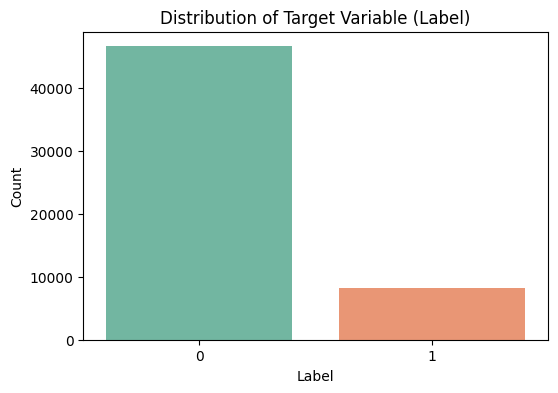

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_7532\44557160.py:53: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Attack_Severity', data=dataset, palette='Set3')


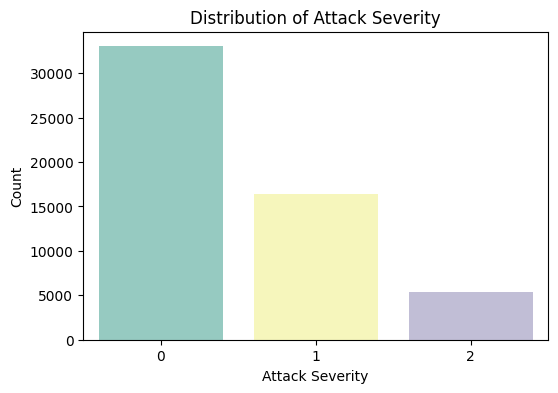

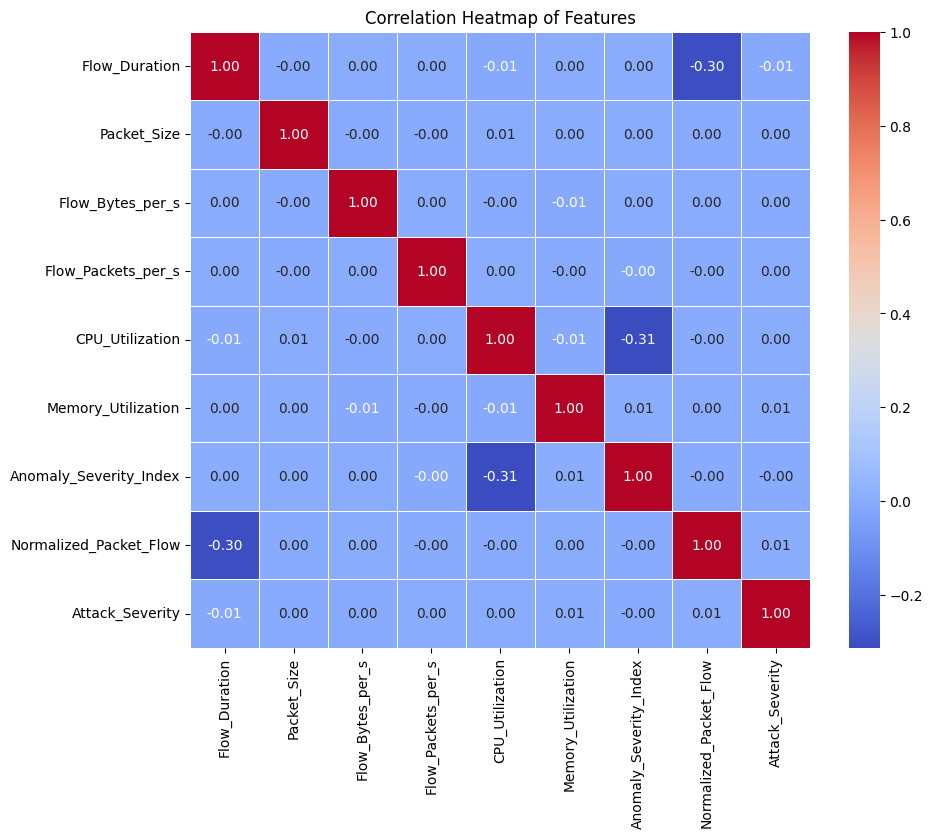

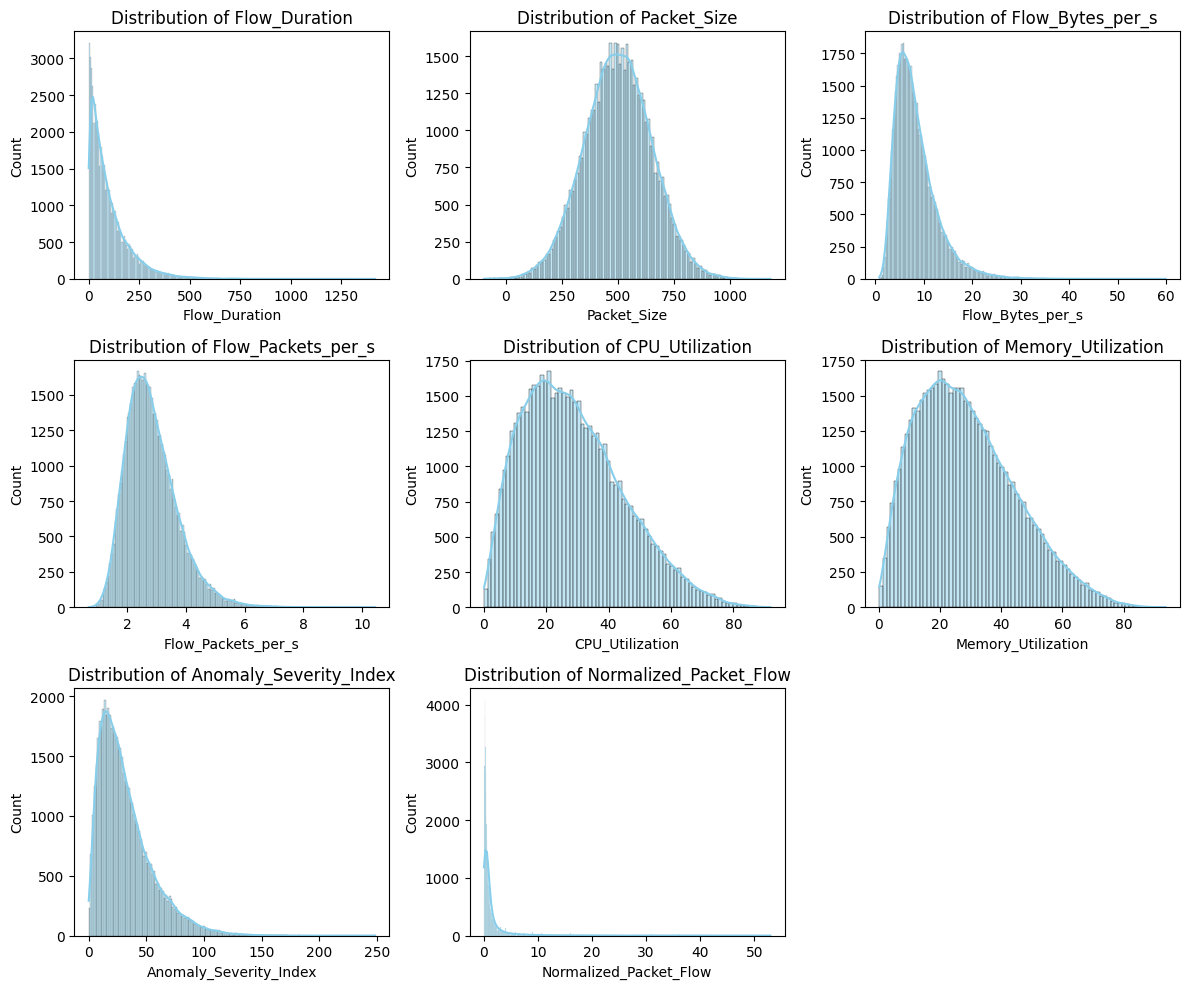

Fitting 3 folds for each of 324 candidates, totalling 972 fits


c:\Users\LENOVO\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [19:10:48] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "scale_pos_weight", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\LENOVO\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [19:10:49] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "scale_pos_weight", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\LENOVO\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [19:10:50] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "scale_pos_weight", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\LENOVO\AppData\Local\Programs\Python\Python313\Lib\site-packages\xg

Best hyperparameters: {'colsample_bytree': 1.0, 'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 300, 'subsample': 0.8}
Classification Report for XGBoost (Attack Severity prediction):
              precision    recall  f1-score   support

           0       0.77      0.70      0.74     13911
           1       0.73      0.80      0.76     14043

    accuracy                           0.75     27954
   macro avg       0.75      0.75      0.75     27954
weighted avg       0.75      0.75      0.75     27954

Confusion Matrix for XGBoost:
[[ 9779  4132]
 [ 2863 11180]]


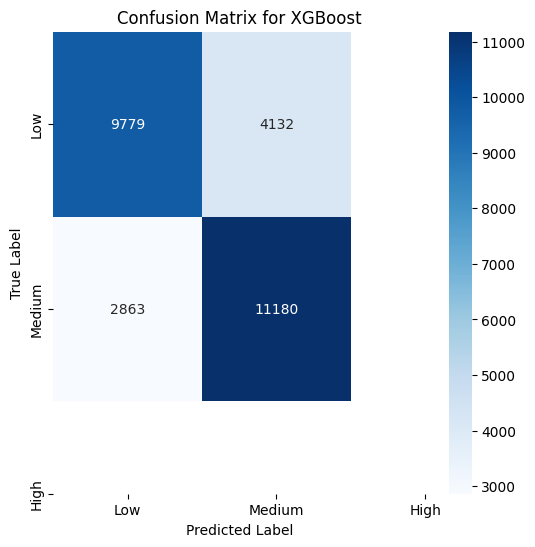

Model dan scaler berhasil disimpan dalam combined_model.pkl


In [9]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder, StandardScaler
from imblearn.over_sampling import SMOTE
import xgboost as xgb
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

# Load dataset
file_path = 'D:/Attack/CTDAPD Dataset.csv'
dataset = pd.read_csv(file_path)

# Preprocess the dataset
# Encode 'Label' column manually to ensure Normal = 0 and Attack = 1
dataset['Label'] = dataset['Label'].map({'Normal': 0, 'Attack': 1})

# Map 'Attack_Severity' to 'Low', 'Medium', 'High' as numeric values (target for prediction)
severity_mapping = {'Low': 0, 'Medium': 1, 'High': 2}
dataset['Attack_Severity'] = dataset['Attack_Severity'].map(severity_mapping)

# EDA: Check for missing values and data types
print("Missing values in dataset:\n", dataset.isnull().sum())
print("\nData types in dataset:\n", dataset.dtypes)

# Select features and target variable (Attack_Severity for prediction)
features = ['Flow_Duration', 'Packet_Size', 'Flow_Bytes_per_s', 'Flow_Packets_per_s', 
            'CPU_Utilization', 'Memory_Utilization', 'Anomaly_Severity_Index', 
            'Normalized_Packet_Flow', 'Attack_Severity']
X = dataset[features]
y = dataset['Label']  # Target variable: Attack_Severity (Low, Medium, High)

# Clean the data: replace inf/-inf with NaN, then fill NaN with column mean
X = X.replace([np.inf, -np.inf], np.nan)
X = X.fillna(X.mean())

# Basic statistics for numerical columns
print("\nDescriptive statistics:\n", dataset.describe())

# Visualizing the distribution of target variable (Label)
plt.figure(figsize=(6, 4))
sns.countplot(x='Label', data=dataset, palette='Set2')
plt.title('Distribution of Target Variable (Label)')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

# Visualizing the distribution of 'Attack_Severity' (target for prediction)
plt.figure(figsize=(6, 4))
sns.countplot(x='Attack_Severity', data=dataset, palette='Set3')
plt.title('Distribution of Attack Severity')
plt.xlabel('Attack Severity')
plt.ylabel('Count')
plt.show()

# Visualizing correlations between features using a heatmap
correlation_matrix = dataset[features].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap of Features')
plt.show()

# Visualizing distributions of numeric features
numeric_features = ['Flow_Duration', 'Packet_Size', 'Flow_Bytes_per_s', 'Flow_Packets_per_s', 
                    'CPU_Utilization', 'Memory_Utilization', 'Anomaly_Severity_Index', 
                    'Normalized_Packet_Flow']

plt.figure(figsize=(12, 10))
for i, feature in enumerate(numeric_features, 1):
    plt.subplot(3, 3, i)
    sns.histplot(dataset[feature], kde=True, color='skyblue')
    plt.title(f'Distribution of {feature}')
    plt.tight_layout()
plt.show()

# Step 1: Handle class imbalance using SMOTE (Synthetic Minority Over-sampling Technique)
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_res, y_res = smote.fit_resample(X, y)

# Step 2: Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.3, random_state=42)

# Scaling the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Step 3: Model training using XGBoost with multi-class classification
model = xgb.XGBClassifier(
    eval_metric="mlogloss", 
    use_label_encoder=False, 
    scale_pos_weight=2,  # Adjusted scale_pos_weight for better imbalance handling
    random_state=42,
    objective='multi:softmax',  # Multi-class classification for Attack_Severity
    num_class=3  # There are 3 classes: Low, Medium, High
)

# Hyperparameter optimization using GridSearchCV
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'n_estimators': [100, 200, 300],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0]
}

# Perform GridSearchCV to find the best hyperparameters
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=StratifiedKFold(n_splits=3), scoring='accuracy', verbose=1)
grid_search.fit(X_train, y_train)

# Best hyperparameters found by GridSearchCV
print(f"Best hyperparameters: {grid_search.best_params_}")

# Using the best model from GridSearchCV
best_model = grid_search.best_estimator_

# Step 4: Make predictions using the tuned model
y_pred = best_model.predict(X_test)

# Step 5: Evaluate the model
print("Classification Report for XGBoost (Attack Severity prediction):")
print(classification_report(y_test, y_pred))

# Confusion matrix for XGBoost
print("Confusion Matrix for XGBoost:")
print(confusion_matrix(y_test, y_pred))

# Plotting the confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Blues", xticklabels=["Low", "Medium", "High"], yticklabels=["Low", "Medium", "High"])
plt.title('Confusion Matrix for XGBoost')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Simpan model dan scaler dalam satu file dictionary
combined = {'model': best_model, 'scaler': scaler}
joblib.dump(combined, 'combined_model.pkl')
print("Model dan scaler berhasil disimpan dalam combined_model.pkl")